#Confronting a Crisis: An Exploratory Textual Analysis of the The Great Depression From Hoover to FDR
###Author: Juliana Torres, julianatorres@berkeley.edu
###Summer 2021

###To get started running this notebook on your computer, follow the steps below:

1. Save this notebook in a dedicated folder in your Google Drive.
2. Inside that same folder, save FDR_speeches.txt and FDR_speeches.csv. Also save Hoover_speeches.txt and Hoover_speeches.csv inside of that folder.
3. Run (press Shift + Return) the cell below and follow the instructions to connect your Google Drive.

In [103]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##From Liberalism to the New Deal in Language
When FDR became president in 1933, he encountered a nation that had nosedived into despair. The Great Depression was entering its fourth year, and the unemployment rate was at 24.9%, the highest in the country's history. Around 26,000 businesses failed. Stock prices plummeted. It transformed American life.

His predecessor Herbert Hoover had been elected only one year before the market crash. A classic liberal, Hoover believed that economic downturns were part of a capitalist economy and were to be expected. As he said in a speech in 1931, government assistance weakened the American character. Hoover hoped that the solution to the Depression would come from voluntary aid and "associational action" by community members and business people and by maintaining a positive mind frame, often making public statements that "the tide had turned." In the eyes of many Americans, President Hoover's response seemed inadequate and uncaring. His nineteen-century approach to Liberalism no longer served the nation's needs, and FDR's New Deal marked the beginning of a new relationship between Americans and their government. 

My project seeks to find linguist evidence of this sentimental shift between Hoover's Liberalism and FDR's New Deal. I want to do so by analyzing FDR's Fireside Chats, a series of 27 speeches transmitted by radio where the president communicated directly with the people, and Hoover's speeches from the start of the Depression until he leaves office. By analyzing the most frequently used words, sentiment, and topics of the speeches, I hope to find what made one so comforting while the other seemed so out of touch.  

In [104]:
#Install new libraries:

##uncomment below to install the following libraries:

#!pip install gensim 
#!pip install pyldavis
#!pip install --upgrade pandas==1.2
# pip install networkx

In [105]:
#Downloading the following libraries:

##basic libraries
import os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from os import path
import re
from collections import Counter

##libraries to clean and organize my text data
import unicodedata
from string import punctuation
import nltk
from nltk.tokenize import word_tokenize
nltk.download ("punkt")
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem.snowball import SnowballStemmer
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")


##visualization library
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.style.use('seaborn-bright')
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams, bigrams, trigrams
#import pyLDAvis
#import pyLDAvis.sklearn
#import pickle 
#import pyLDAvis
import spacy
import seaborn as sns

#Topic Modelling and Machine Learning
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#Sentiment Analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer



import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


###Gathering the Data
For this project, I used the transcription of 27 Fireside Chats available via The American Presidency Project at UCSB and Hoover speeches offered by the Miller Center at the University of Virginia. I manually copied and pasted them in separate Google Drive files and exported them as a .csv file.

The American Presidency Project: https://www.presidency.ucsb.edu/documents/app-categories/spoken-addresses-and-remarks/presidential/fireside-chats

The Miller Center: https://millercenter.org/the-presidency/presidential-speeches


Below I will import the data organized by date on a .csv file and present it in a dataframe. 

In [106]:
#Loading the dataframe in .csv

FDR_speeches = pd.read_csv('/content/drive/My Drive/Juliana/FDR_speeches.csv')
Hoover_speeches = pd.read_csv('/content/drive/My Drive/Juliana/Hoover_speeches.csv')


Below is FDR's speeches presented in a dataframe:

In [107]:
FDR_speeches.head()

Number  ...                                             Speech
0       1  ...  “I want to talk for a few minutes with the peo...
1       2  ...  “On A Sunday night a week after my Inauguratio...
2       3  ...  “After the adjournment of the historical speci...
3       4  ...  “It is three months since I have talked with t...
4       5  ...  “It has been several months since I have talke...

[5 rows x 4 columns]

And here are Hoover's speeches presented in a dataframe:


In [108]:
Hoover_speeches.head()

Number  ...                                             Speech
0       1  ...  "The fundamental business of the country, that...
1       2  ...  “I haven't anything of any news here to announ...
2       3  ...  “We are dealing here with a psychological situ...
3       4  ...  "To the Senate and House of Representatives: T...
4       5  ...  "The Departments of Commerce and Labor are eng...

[5 rows x 4 columns]

###Organizing and Cleaning the Data:
For this project, it was really important to understand the text in the word level, so I wanted to use n-grams and wordclouds to understand word repetiton and try to identify the target of those messages.

Since I was dealing with a reasonable amount of text, I manually copied all the speeches into their separate .txt files and used some of the above libraries to perform the following cleaning and preparing steps:

  1. Load the new dataframe in .txt
  2. Tokenize the text so that each word in separated. I will use .split() to do it.
  3. Remove punctuations. 
  4. Remove stopwords, frequently used words that do not add to the analysis. 
  5. Lemmatization of the words to standardize the text. This will give you     results that are more relevant and comprehensive. 
 

In [109]:
#Loading #Spacy pre-trained model:

nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat"])

In [110]:
#Loading the dataframe in .txt:

with open ('/content/drive/My Drive/Juliana/FDR_speeches.txt', "r") as myfile:
    FDR_speeches_text=myfile.readlines()

with open ('/content/drive/My Drive/Juliana/Hoover_speeches.txt', "r") as myfile:
    Hoover_speeches_text=myfile.readlines()


In [111]:
#Now I will create a function to lemmatize FDR's speeches. Since SpaCy models operate on string and not lists, I will first turn the tokens back into a string:

def lemmatize(string):
  doc = nlp(string)
  return [token.lemma_.lower() for token in doc]

FDR_lemmas = lemmatize(FDR_speeches_text[0])
Hoover_lemmas = lemmatize(Hoover_speeches_text[0])

print(FDR_lemmas)
print(Hoover_lemmas)





['-pron-', 'want', 'to', 'talk', 'for', 'a', 'few', 'minute', 'with', 'the', 'people', 'of', 'the', 'united', 'states', 'about', 'banking', '—', 'with', 'the', 'comparatively', 'few', 'who', 'understand', 'the', 'mechanic', 'of', 'banking', 'but', 'more', 'particularly', 'with', 'the', 'overwhelming', 'majority', 'who', 'use', 'bank', 'for', 'the', 'making', 'of', 'deposit', 'and', 'the', 'drawing', 'of', 'check', '.', '-pron-', 'want', 'to', 'tell', '-pron-', 'what', 'have', 'be', 'do', 'in', 'the', 'last', 'few', 'day', ',', 'why', '-pron-', 'be', 'do', ',', 'and', 'what', 'the', 'next', 'step', 'be', 'go', 'to', 'be', '.', '-pron-', 'recognize', 'that', 'the', 'many', 'proclamation', 'from', 'state', 'capitol', 'and', 'from', 'washington', ',', 'the', 'legislation', ',', 'the', 'treasury', 'regulation', ',', 'etc', '.', ',', 'couch', 'for', 'the', 'most', 'part', 'in', 'banking', 'and', 'legal', 'term', ',', 'should', 'be', 'explain', 'for', 'the', 'benefit', 'of', 'the', 'average',

In [112]:
#Tokenizing FDR's speeches. Note the difference:

FDR_tokenized = FDR_speeches_text[0].split()
print(FDR_tokenized)
print(len(FDR_speeches_text))
print(len(FDR_tokenized))

['I', 'want', 'to', 'talk', 'for', 'a', 'few', 'minutes', 'with', 'the', 'people', 'of', 'the', 'United', 'States', 'about', 'banking—with', 'the', 'comparatively', 'few', 'who', 'understand', 'the', 'mechanics', 'of', 'banking', 'but', 'more', 'particularly', 'with', 'the', 'overwhelming', 'majority', 'who', 'use', 'banks', 'for', 'the', 'making', 'of', 'deposits', 'and', 'the', 'drawing', 'of', 'checks.', 'I', 'want', 'to', 'tell', 'you', 'what', 'has', 'been', 'done', 'in', 'the', 'last', 'few', 'days,', 'why', 'it', 'was', 'done,', 'and', 'what', 'the', 'next', 'steps', 'are', 'going', 'to', 'be.', 'I', 'recognize', 'that', 'the', 'many', 'proclamations', 'from', 'State', 'capitols', 'and', 'from', 'Washington,', 'the', 'legislation,', 'the', 'Treasury', 'regulations,', 'etc.,', 'couched', 'for', 'the', 'most', 'part', 'in', 'banking', 'and', 'legal', 'terms,', 'should', 'be', 'explained', 'for', 'the', 'benefit', 'of', 'the', 'average', 'citizen.', 'I', 'owe', 'this', 'in', 'parti

In [113]:
#Tokenizing Hoover's speeches:

Hoover_tokenized = Hoover_speeches_text[0].split()
print(Hoover_tokenized)
print(len(Hoover_speeches_text))
print(len(Hoover_tokenized))



['The', 'fundamental', 'business', 'of', 'the', 'country,', 'that', 'is', 'the', 'production', 'and', 'distribution', 'of', 'commodities,', 'is', 'on', 'a', 'sound', 'and', 'prosperous', 'basis.', 'The', 'best', 'evidence', 'is', 'that', 'although', 'production', 'and', 'consumption', 'are', 'at', 'high', 'levels,', 'the', 'average', 'prices', 'of', 'commodities', 'as', 'a', 'whole', 'have', 'not', 'increased', 'and', 'there', 'have', 'been', 'no', 'appreciable', 'increases', 'in', 'the', 'stocks', 'of', 'manufactured', 'goods.', 'Moreover,', 'there', 'has', 'been', 'a', 'tendency', 'of', 'wages', 'to', 'increase,', 'the', 'output', 'per', 'worker', 'in', 'many', 'industries', 'again', 'shows', 'an', 'increase,', 'all', 'of', 'which', 'indicates', 'a', 'healthy', 'condition.The', 'construction', 'and', 'building', 'material', 'industries', 'have', 'been', 'to', 'some', 'extent', 'affected', 'by', 'the', 'high', 'interest', 'rates', 'induced', 'by', 'stock', 'speculation', 'and', 'there

In [114]:
#Removing punctuation from FDR's speeches:

FDR_lemmatized_no_punc = [re.sub(r"[^\w\s]", "", sent) for sent in FDR_lemmas] 
print(FDR_lemmatized_no_punc)


['pron', 'want', 'to', 'talk', 'for', 'a', 'few', 'minute', 'with', 'the', 'people', 'of', 'the', 'united', 'states', 'about', 'banking', '', 'with', 'the', 'comparatively', 'few', 'who', 'understand', 'the', 'mechanic', 'of', 'banking', 'but', 'more', 'particularly', 'with', 'the', 'overwhelming', 'majority', 'who', 'use', 'bank', 'for', 'the', 'making', 'of', 'deposit', 'and', 'the', 'drawing', 'of', 'check', '', 'pron', 'want', 'to', 'tell', 'pron', 'what', 'have', 'be', 'do', 'in', 'the', 'last', 'few', 'day', '', 'why', 'pron', 'be', 'do', '', 'and', 'what', 'the', 'next', 'step', 'be', 'go', 'to', 'be', '', 'pron', 'recognize', 'that', 'the', 'many', 'proclamation', 'from', 'state', 'capitol', 'and', 'from', 'washington', '', 'the', 'legislation', '', 'the', 'treasury', 'regulation', '', 'etc', '', '', 'couch', 'for', 'the', 'most', 'part', 'in', 'banking', 'and', 'legal', 'term', '', 'should', 'be', 'explain', 'for', 'the', 'benefit', 'of', 'the', 'average', 'citizen', '', 'pron

In [115]:
#Removing punctuation from Hoover's speeches:

Hoover_lemmatized_no_punc = [re.sub(r"[^\w\s]", "", sent) for sent in Hoover_lemmas] 
print(Hoover_lemmatized_no_punc)

['the', 'fundamental', 'business', 'of', 'the', 'country', '', 'that', 'be', 'the', 'production', 'and', 'distribution', 'of', 'commodity', '', 'be', 'on', 'a', 'sound', 'and', 'prosperous', 'basis', '', 'the', 'good', 'evidence', 'be', 'that', 'although', 'production', 'and', 'consumption', 'be', 'at', 'high', 'level', '', 'the', 'average', 'price', 'of', 'commodity', 'as', 'a', 'whole', 'have', 'not', 'increase', 'and', 'there', 'have', 'be', 'no', 'appreciable', 'increase', 'in', 'the', 'stock', 'of', 'manufacture', 'good', '', 'moreover', '', 'there', 'have', 'be', 'a', 'tendency', 'of', 'wage', 'to', 'increase', '', 'the', 'output', 'per', 'worker', 'in', 'many', 'industry', 'again', 'show', 'an', 'increase', '', 'all', 'of', 'which', 'indicate', 'a', 'healthy', 'condition', '', 'the', 'construction', 'and', 'building', 'material', 'industry', 'have', 'be', 'to', 'some', 'extent', 'affect', 'by', 'the', 'high', 'interest', 'rate', 'induce', 'by', 'stock', 'speculation', 'and', 'th

In [116]:
#Tagging and categorizing FDR's speech:

nltk.pos_tag(FDR_tokenized)

[('I', 'PRP'),
 ('want', 'VBP'),
 ('to', 'TO'),
 ('talk', 'VB'),
 ('for', 'IN'),
 ('a', 'DT'),
 ('few', 'JJ'),
 ('minutes', 'NNS'),
 ('with', 'IN'),
 ('the', 'DT'),
 ('people', 'NNS'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('United', 'NNP'),
 ('States', 'NNPS'),
 ('about', 'IN'),
 ('banking—with', 'PDT'),
 ('the', 'DT'),
 ('comparatively', 'RB'),
 ('few', 'JJ'),
 ('who', 'WP'),
 ('understand', 'VBP'),
 ('the', 'DT'),
 ('mechanics', 'NNS'),
 ('of', 'IN'),
 ('banking', 'NN'),
 ('but', 'CC'),
 ('more', 'JJR'),
 ('particularly', 'RB'),
 ('with', 'IN'),
 ('the', 'DT'),
 ('overwhelming', 'JJ'),
 ('majority', 'NN'),
 ('who', 'WP'),
 ('use', 'VBP'),
 ('banks', 'NNS'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('making', 'NN'),
 ('of', 'IN'),
 ('deposits', 'NNS'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('drawing', 'NN'),
 ('of', 'IN'),
 ('checks.', 'NN'),
 ('I', 'PRP'),
 ('want', 'VBP'),
 ('to', 'TO'),
 ('tell', 'VB'),
 ('you', 'PRP'),
 ('what', 'WDT'),
 ('has', 'VBZ'),
 ('been', 'VBN'),
 ('done', 'VBN'),
 ('in', '

In [ ]:
#Tagging and categorizing FDR's speech:

nltk.pos_tag(Hoover_tokenized)

###Visualizing the data: Wordclouds and Barplots



> Wordclouds and Barplots


To get an early insight into the data and see the most obvious distinctions, it can be useful to create a wordcloud with the most frequently used words in the text. 

To create the wordcloud, import your textual data and perform the steps above to prepare the text for analysis. While creating the wordcloud, remove the stop words to have a more relevant result.

To make the results more obvious and provide some numerical data, I will plot the most common words in a barplot using matplotlib.

Below is the code to create your wordcloud and barplots. Don't forget to replace the data with your own document. 

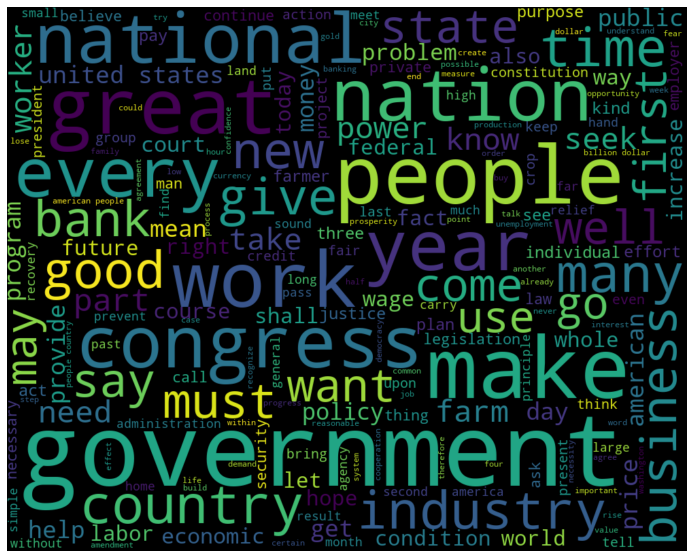

In [118]:
#Creating a wordcloud for FDR's speeches and excluding stopwords: 


stop_words = set(stopwords.words("english"))
stop_words.update(["war", "peace", "would", "thus", "Japanese", "one", "two", " ", "", "-pron-", "pron", "-"])


def make_wordcloud(speech_lemmas):
  speech_string = " ".join(speech_lemmas)
  wordcloud = WordCloud(width=1000, height=800, mode="RGBA", background_color ='black',
    stopwords = stop_words).generate(speech_string)
  
  plt.figure( figsize=(20,10) )
  plt.imshow(wordcloud, interpolation='bilinear') 
  plt.axis("off")
  plt.show()
  
make_wordcloud(FDR_lemmatized_no_punc)







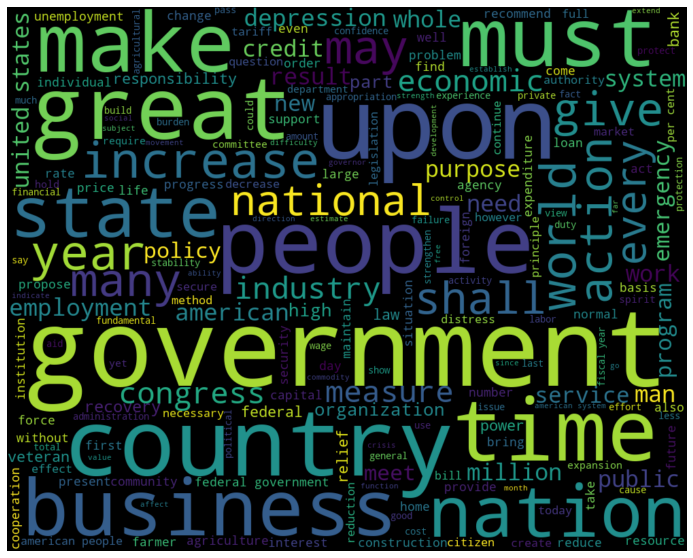

In [119]:
#And here is a wordcloud for Hoover's speeches:

make_wordcloud(Hoover_lemmatized_no_punc)


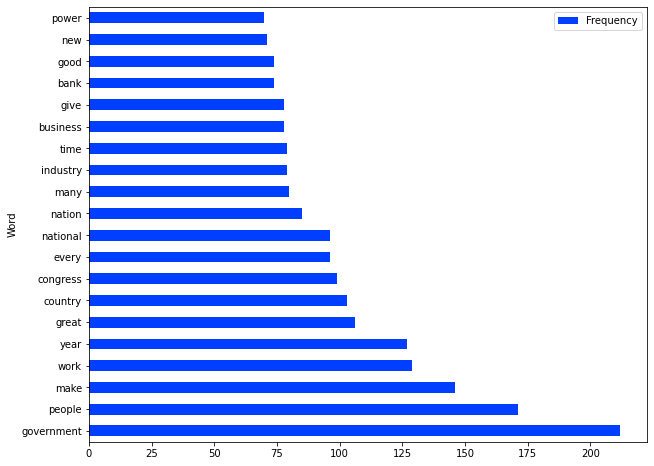

In [120]:
#Counting word frequency of the 20 most used words and then using Matplotlib to visualize it in a graph:

FDR_no_stop = [word for word in FDR_lemmatized_no_punc if word not in stop_words]
FDR_freq = Counter(FDR_no_stop)
FDR_barplot = FDR_freq.most_common(20)

FDR_df = pd.DataFrame(data = FDR_barplot, columns = ["Word", "Frequency"]);
FDR_df.plot.barh(x = "Word", y = "Frequency", figsize = (10,8));

plt.savefig("FDR_bar.png")




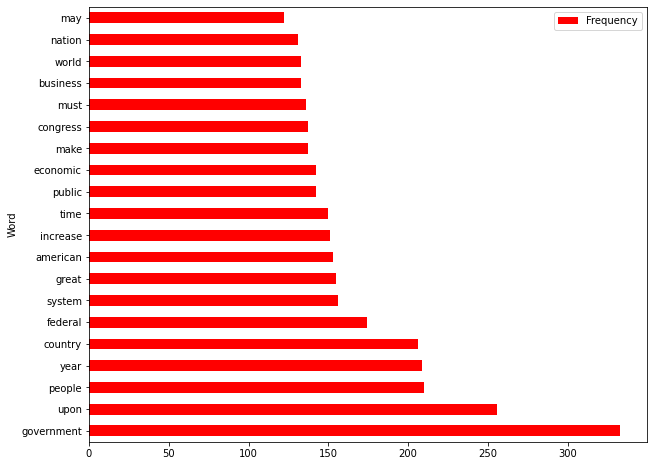

In [121]:
#Doing the same for Hoover: 

Hoover_no_stop = [word for word in Hoover_lemmatized_no_punc if word not in stop_words]
Hoover_freq = Counter(Hoover_no_stop)
Hoover_barplot = Hoover_freq.most_common(20)

Hoover_df = pd.DataFrame(data = Hoover_barplot, columns = ["Word", "Frequency"])
                         
Hoover_df.plot.barh(x = "Word", y = "Frequency", color = "red",  figsize = (10,8));

###Visualizing the data: N-Grams

> N-Grams

N-Grams are sequences of *n* words, *n* being a discrete number that can go from 1 to infinity. 

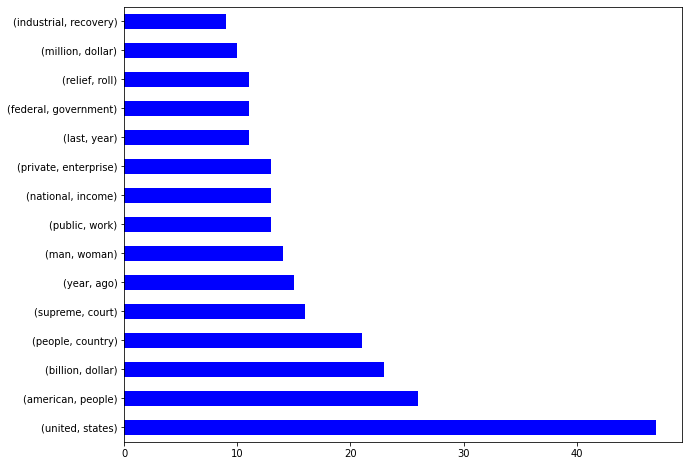

In [122]:
#FDR Bigram
FDR_bi = (pd.Series(nltk.ngrams(FDR_no_stop, 2)).value_counts())[:15]
#print(type(FDR_bi))

FDR_bi.plot.barh(x = "Frequency", y = "Bigram", color = "blue", figsize = (10,8));




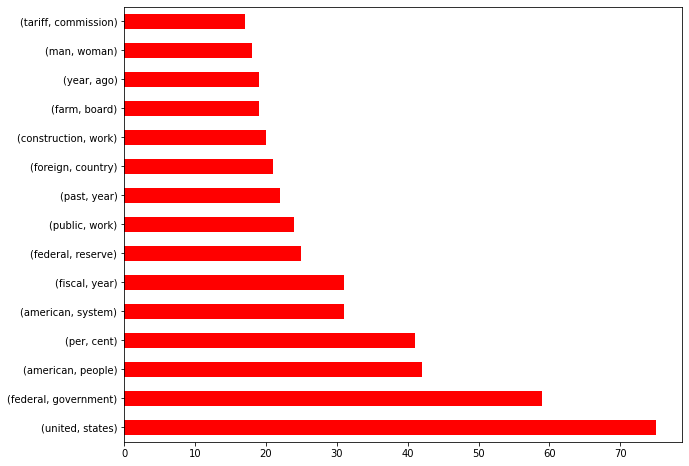

In [123]:
#Hoover Bigram
Hoover_bi = (pd.Series(nltk.ngrams(Hoover_no_stop, 2)).value_counts())[:15]

Hoover_bi.plot.barh(x = "Frequency", y = "Bigram", color = "red", figsize = (10,8));

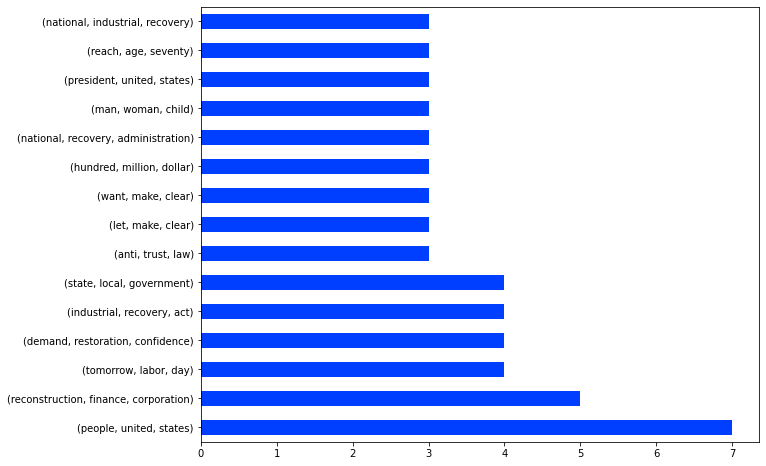

In [124]:
#FDR Tri-gram
FDR_tri = (pd.Series(nltk.ngrams(FDR_no_stop, 3, )).value_counts())[:15]

FDR_tri.plot.barh(x = "Frequency", y = "Trigram", figsize = (10,8));
                                                   

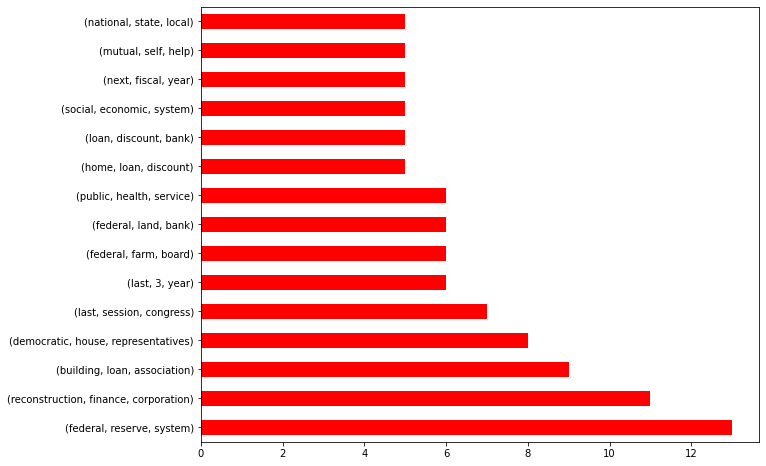

In [125]:
Hoover_tri = (pd.Series(nltk.ngrams(Hoover_no_stop, 3)).value_counts())[:15]
Hoover_tri.plot.barh(x = "Frequency", y = "Trigram", color = "red", figsize = (10,8));

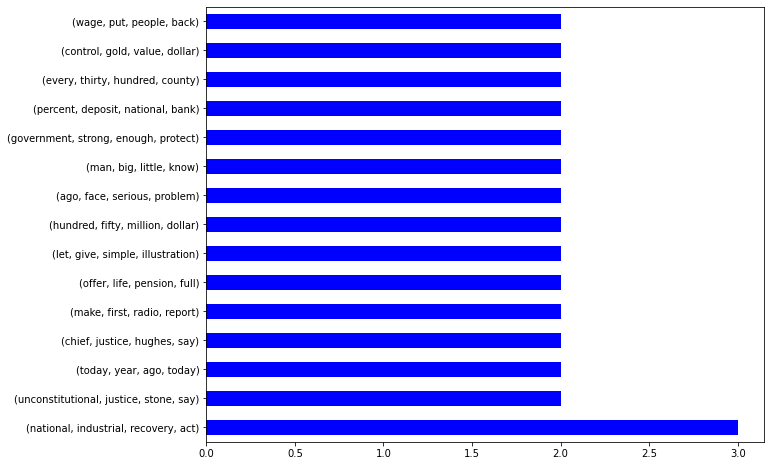

In [126]:
#FDR fourgrams:

FDR_four = (pd.Series(nltk.ngrams(FDR_no_stop, 4)).value_counts())[:15]


FDR_four.plot.barh(x = "Frequency", y = "Bigram", color = "blue", figsize = (10,8));


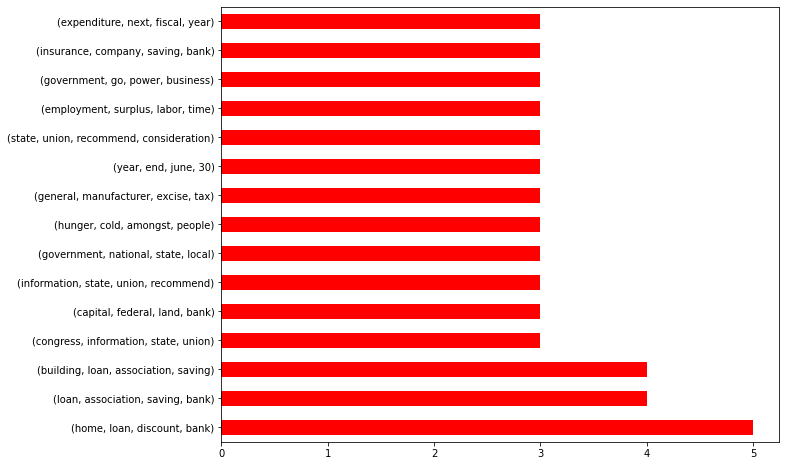

In [127]:
#Hoover fourgrams:

Hoover_four = (pd.Series(nltk.ngrams(Hoover_no_stop, 4)).value_counts())[:15]


Hoover_four.plot.barh(x = "Frequency", y = "Bigram", color = "red", figsize = (10,8));


###Visualizing the data: TF-IDF



> TF-IDF 

In [128]:
#Importing new dataframe

collected = pd.read_csv("/content/drive/My Drive/Juliana/collected.csv")
collected.head()

Date Name                                             Speech
0  1933  FDR  “I want to talk for a few minutes with the peo...
1  1933  FDR  “On A Sunday night a week after my Inauguratio...
2  1933  FDR  “After the adjournment of the historical speci...
3  1933  FDR  “It is three months since I have talked with t...
4  1934  FDR  “It has been several months since I have talke...

In [129]:
#Basic cleaning

def remove_digits(speeches):

    return ''.join([ch for ch in speeches if not ch.isdigit()])

collected['body_without_digits'] = collected['Speech'].apply(remove_digits)
collected ['clean'] = collected['body_without_digits'].map(lambda x: x.lower())
collected ['clean'] = collected ['clean'].str.replace('“\d+"', '')
collected ['clean'] = collected ['clean'].str.replace('[“|”]', '')
collected ['clean'] = [word for word in collected ['clean'] if word not in stop_words]
print(collected['clean'])









0     i want to talk for a few minutes with the peop...
1     on a sunday night a week after my inauguration...
2     after the adjournment of the historical specia...
3     it is three months since i have talked with th...
4     it has been several months since i have talked...
5     three months have passed since i talked with y...
6     since my annual message to the congress on jan...
7     i have been on a journey of husbandry. i went ...
8     last thursday i described in detail certain ec...
9     this afternoon i have issued a proclamation ca...
10    five months have gone by since i last spoke to...
11    our government, happily, is a democracy. as pa...
12    my fellow americans and my friends: tonight my...
13    the fundamental business of the country, that ...
14    i haven't anything of any news here to announc...
15    we are dealing here with a psychological situa...
16    to the senate and house of representatives: th...
17    the departments of commerce and labor are 

In [130]:
#Getting the TFIDF for the clean data and adding stop_words

tfidfvec = TfidfVectorizer(stop_words={'english'})
stop_words.update(["the", "of", "and", "to", "in"])
sparse_tfidf = tfidfvec.fit_transform(collected ['clean'])
print(sparse_tfidf)

  (0, 2315)	0.008568807351724285
  (0, 827)	0.006185014498001186
  (0, 5986)	0.006392845740768929
  (0, 3702)	0.013248561174255147
  (0, 3438)	0.005797502423730833
  (0, 4481)	0.006392845740768929
  (0, 4998)	0.007912172394507568
  (0, 3555)	0.007912172394507568
  (0, 4588)	0.006611339556063269
  (0, 555)	0.016201157100279633
  (0, 6203)	0.014473999203773253
  (0, 2733)	0.016201157100279633
  (0, 5122)	0.016201157100279633
  (0, 5553)	0.014473999203773253
  (0, 2326)	0.007618283770287034
  (0, 3820)	0.010228983117423047
  (0, 4293)	0.007912172394507568
  (0, 848)	0.009345441666793415
  (0, 2141)	0.016201157100279633
  (0, 1372)	0.007618283770287034
  (0, 2986)	0.012370028996002373
  (0, 4708)	0.010864768320532053
  (0, 1979)	0.014473999203773253
  (0, 179)	0.005616211425699799
  (0, 4488)	0.009345441666793415
  :	:
  (31, 1466)	0.006247139768994107
  (31, 3382)	0.014059102757116734
  (31, 3014)	0.22540229926259808
  (31, 601)	0.03622536952434612
  (31, 2783)	0.04148898247825147
  (31, 

In [131]:
#And turning into a Pandas dataframe for easy visualization

tfidf = pd.DataFrame(sparse_tfidf.toarray(), columns=tfidfvec.get_feature_names())
tfidf.head(n = 50)

abandon  abandoned  abandoning  ...      zinc      zone     zones
0   0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
1   0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
2   0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
3   0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
4   0.000000   0.000000    0.000000  ...  0.000000  0.010501  0.000000
5   0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
6   0.007770   0.000000    0.000000  ...  0.000000  0.000000  0.000000
7   0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
8   0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
9   0.000000   0.000000    0.010479  ...  0.000000  0.000000  0.000000
10  0.005425   0.000000    0.000000  ...  0.000000  0.000000  0.000000
11  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
12  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
13  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
14  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
15  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
16  0.000000   0.000000    0.000000  ...  0.000000  0.003530  0.003952
17  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
18  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
19  0.000000   0.000000    0.000000  ...  0.014662  0.000000  0.000000
20  0.000000   0.000000    0.000000  ...  0.005800  0.000000  0.000000
21  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
22  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
23  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
24  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
25  0.004196   0.004521    0.000000  ...  0.000000  0.000000  0.000000
26  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
27  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
28  0.000000   0.003433    0.000000  ...  0.000000  0.000000  0.000000
29  0.003488   0.003758    0.000000  ...  0.000000  0.000000  0.000000
30  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000
31  0.000000   0.000000    0.000000  ...  0.000000  0.000000  0.000000

[32 rows x 6611 columns]

In [132]:
#Looking at the highest TF-IDF scores to identify the most distinctive words:

tfidf.max().sort_values(ascending=False).head(25)

the             0.674291
of              0.506989
and             0.359699
to              0.354353
in              0.249609
veterans        0.246327
tariff          0.243280
are             0.224402
that            0.223262
grain           0.204996
harvest         0.204996
banks           0.198178
market          0.190319
court           0.187166
is              0.178991
bank            0.169850
our             0.167862
unemployment    0.159702
phenomenon      0.159193
law             0.156531
deprives        0.155178
mistaken        0.155178
percent         0.154440
it              0.153968
interior        0.151878
dtype: float64

In [133]:
#With these scores, I can identify the most distinctive words in each text:

tfidf['name_'] = collected['Name']
tfidf.head()

abandon  abandoned  abandoning  abandonment  ...  zinc      zone  zones  name_
0      0.0        0.0         0.0          0.0  ...   0.0  0.000000    0.0    FDR
1      0.0        0.0         0.0          0.0  ...   0.0  0.000000    0.0    FDR
2      0.0        0.0         0.0          0.0  ...   0.0  0.000000    0.0    FDR
3      0.0        0.0         0.0          0.0  ...   0.0  0.000000    0.0    FDR
4      0.0        0.0         0.0          0.0  ...   0.0  0.010501    0.0    FDR

[5 rows x 6612 columns]

In [134]:
FDR = tfidf[tfidf['name_'] == 'FDR']
Hoover = tfidf[tfidf['name_'] == 'Hoover']


In [135]:
FDR.max(numeric_only=True).sort_values(ascending=False).head(10)

the      0.638841
of       0.479013
to       0.354353
and      0.327266
in       0.249609
that     0.213872
banks    0.198178
court    0.187166
bank     0.169850
it       0.153968
dtype: float64

In [136]:
Hoover.max(numeric_only=True).sort_values(ascending=False).head(10)

the         0.674291
of          0.506989
and         0.359699
to          0.342276
veterans    0.246327
tariff      0.243280
in          0.242730
are         0.224402
that        0.223262
grain       0.204996
dtype: float64

###Visualizing the data: Topic Modelling



> Topic Modelling

 In order to get more context from the speeches and the frequently used words, I will create a topic model for each president and analyze how they compare. I predict that FDR will have themes more accesible to the American people, while Hoover will comment more on technical and economic terms that apply more to the business class. 

 This difference in topics might help us understand what made FDR's speeches resonate with the people. 

Since I already processed my data above, I will use my clean variable to fit a topic model for each president. 

Again going from the most abstract to the most spectific, I will use LDA, a unsupervised machine learning text-mining tool that can be used to discover abstract "topics" in texts. Here are some of the most important steps I will take to get there:

1.   Create a dataframe from individual text files
2.   Clean the text within the dataframe
3.   Define a Bag of Words (BOW) model
4.   Create a Document Term Matrix (DTM)
      *   Here I will do some extra processing like identifying bigrams and creating a wordcloud so we can have more insight into the overall vocabulary of these texts. One of the things we can learn, for example, is what terms are at the top of this list and who do they belong to? We know the power of repetition in crafting a message, so tracking down who did more successfully might help us understand who had the most effective rhetoric. 
5.   Fit the topic model













In [137]:
#First we join our speeches into one single string:

long_string = ','.join(list(collected['clean'].values))
long_string

"i want to talk for a few minutes with the people of the united states about banking with the comparatively few who understand the mechanics of banking but more particularly with the overwhelming majority who use banks for the making of deposits and the drawing of checks. i want to tell you what has been done in the last few days, why it was done, and what the next steps are going to be. i recognize that the many proclamations from state capitols and from washington, the legislation, the treasury regulations, etc., couched for the most part in banking and legal terms, should be explained for the benefit of the average citizen. i owe this in particular because of the fortitude and good temper with which everybody has accepted the inconvenience and hardships of the banking holiday. i know that when you understand what we in washington have been about i shall continue to have your cooperation as fully as i have had your sympathy and help during the past week. first of all, let me state th

In [138]:
#And use CountVectorizer to do some exploratory data analysis like word frequency and wordclouds

bigram_vectorizer = CountVectorizer(ngram_range = (1,2),
                                    stop_words = "english",
                                    token_pattern = r'\b\w+\b', 
                                    min_df = 1)
bigram_vectorizer


analyze = bigram_vectorizer.build_analyzer()
vocab = analyze(long_string)

In [139]:
freq = Counter(vocab)
stop_df = pd.DataFrame(freq.most_common(20), columns = ["Word", "Frequency"])


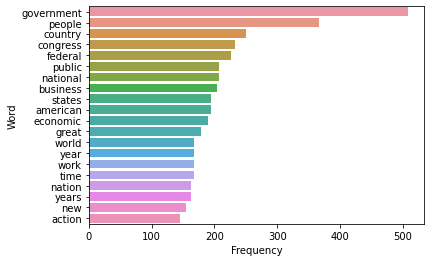

In [140]:
allspeeches_barplot = sns.barplot(x = "Frequency", 
                         y = "Word", 
                         data = stop_df, 
                         orient = "h")


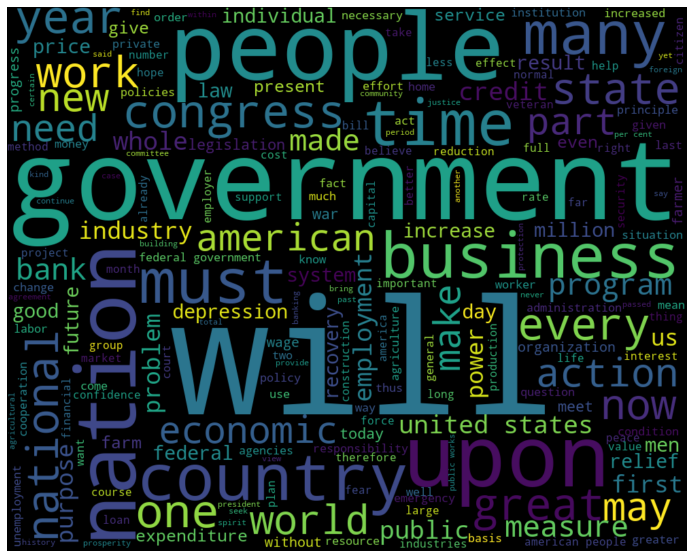

In [141]:
#Creating a wordcloud:

wordcloud = WordCloud(width=1000, height=800, mode="RGBA", background_color ='black')

wordcloud.generate(long_string)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

In [142]:
#Step 2.2: Now I will tokenize this long_string:

all_speeches_tokens = long_string.split()


In [143]:
#Step 3: Define a Bag of Words (BOW) model

vectorizer = CountVectorizer()
vectorizer.fit(collected ['clean'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [144]:
#Step 4: Create a Document Term Matrix (DTM)

#Encoding both documents:
#NOTE: the column headers should read "(document number, term) frequency"

vector = vectorizer.transform(collected ['clean'])
print(vector)
print(vector.toarray())


  (0, 7)	1
  (0, 8)	1
  (0, 14)	4
  (0, 25)	1
  (0, 38)	1
  (0, 39)	1
  (0, 50)	1
  (0, 87)	1
  (0, 93)	1
  (0, 94)	1
  (0, 104)	1
  (0, 111)	1
  (0, 175)	1
  (0, 179)	1
  (0, 181)	1
  (0, 182)	2
  (0, 202)	1
  (0, 223)	1
  (0, 225)	14
  (0, 242)	3
  (0, 246)	1
  (0, 251)	2
  (0, 252)	2
  (0, 265)	1
  (0, 285)	2
  :	:
  (31, 6474)	1
  (31, 6475)	24
  (31, 6476)	2
  (31, 6480)	3
  (31, 6481)	6
  (31, 6484)	1
  (31, 6486)	2
  (31, 6487)	1
  (31, 6488)	1
  (31, 6494)	2
  (31, 6497)	19
  (31, 6508)	2
  (31, 6516)	3
  (31, 6521)	23
  (31, 6532)	6
  (31, 6533)	4
  (31, 6537)	1
  (31, 6551)	3
  (31, 6556)	1
  (31, 6557)	1
  (31, 6561)	9
  (31, 6562)	13
  (31, 6573)	8
  (31, 6587)	8
  (31, 6589)	5
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [145]:
#Want to know what these numbers are? Uncomment below to identify these terms:

print(vectorizer.get_feature_names())

['abandon', 'abandoned', 'abandoning', 'abandonment', 'abide', 'abiding', 'abilities', 'ability', 'able', 'abnormal', 'abnormally', 'abolish', 'abolished', 'abolition', 'about', 'above', 'abraham', 'abroad', 'abrogation', 'absence', 'absentee', 'absolute', 'absolutely', 'absorbed', 'abstract', 'abundance', 'abundant', 'abundantly', 'abuse', 'abuses', 'abyss', 'academic', 'accelerate', 'accelerated', 'accelerates', 'acceleration', 'accentuate', 'accept', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accidents', 'accommodation', 'accompanied', 'accompany', 'accomplish', 'accomplished', 'accomplishing', 'accomplishment', 'accomplishments', 'accord', 'accordance', 'according', 'accordingly', 'accords', 'account', 'accountants', 'accounts', 'accredit', 'accredited', 'accrue', 'accumulate', 'accumulated', 'accumulation', 'accuracy', 'accurately', 'accusation', 'accuse', 'accusing', 'accustomed', 'achieve', 'achieved', 'achievements', 'acknowledged', 'acquaint', 'acquire', 'acq

In [146]:
#Step 5: Fitting the topic model!

n_topics = 3

tfidf_vectorizer = TfidfVectorizer(max_df = 0.99,
                                   max_features = 100,
                                   stop_words = "english")
tfidf = tfidf_vectorizer.fit_transform(all_speeches_tokens)


In [147]:
#Step 5.1: Initiating the LDA model:

lda = LatentDirichletAllocation(n_components = n_topics, 
                                max_iter = 20, 
                                random_state = 5)
lda = lda.fit(tfidf)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 10)


Topic #0:
people national year action shall industry state measures large life

Topic #1:
government public american world work nation years new banks power

Topic #2:
country congress federal business states economic great time employment credit


###Visualizing the data: Word2Vec



> Word2Vec


In [148]:
#Converting the document into a separate dataframe with just one comlumn

w2v_df = pd.DataFrame({'New Processed': collected ['clean']})
w2v_df

New Processed
0   i want to talk for a few minutes with the peop...
1   on a sunday night a week after my inauguration...
2   after the adjournment of the historical specia...
3   it is three months since i have talked with th...
4   it has been several months since i have talked...
5   three months have passed since i talked with y...
6   since my annual message to the congress on jan...
7   i have been on a journey of husbandry. i went ...
8   last thursday i described in detail certain ec...
9   this afternoon i have issued a proclamation ca...
10  five months have gone by since i last spoke to...
11  our government, happily, is a democracy. as pa...
12  my fellow americans and my friends: tonight my...
13  the fundamental business of the country, that ...
14  i haven't anything of any news here to announc...
15  we are dealing here with a psychological situa...
16  to the senate and house of representatives: th...
17  the departments of commerce and labor are enga...
18  i shall approve the tariff bill. this legislat...
19  members of the american bankers association an...
20  to the senate and house of representatives: i ...
21  i observe that measures have been already intr...
22  certain senators have issued a public statemen...
23  to the house of representatives. i return here...
24  my fellow citizens. this broadcast tonight mar...
25  to the senate and house of representatives: it...
26  in my recommendations to congress and in the o...
27  an emergency has developed in the last few day...
28  mr. chairman and my fellow citizens. in accept...
29  this campaign is more than a contest between t...
30  in these closing hours of the campaign i am co...
31  to the senate and house of representatives: in...

In [149]:
#Splitting each row into a list:


def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        newStopWords = ['to','and']
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in newStopWords:
            result.extend(lemmatize(token))
    return result

preclean = [preprocess(row) for row in w2v_df['New Processed']]






In [150]:
#Defyning a Word2Vec model and saving the vocabulary:

model = gensim.models.Word2Vec(sentences = preclean, 
                               min_count = 2,
                               workers = 3, 
                               window = 3, 
                               
                               )

words = list(model.wv.vocab)


In [ ]:
model.wv["government"]

In [ ]:
model.wv.most_similar("government")

In [ ]:
model.wv.most_similar("help")

In [ ]:
model.wv.most_similar("depression")

In [155]:
#Start comparing!

model.wv.similarity("government","help")


0.99987113

In [156]:
government_model = model.wv.most_similar(positive = "government", topn=10)
print(government_model)

[('great', 0.9999345541000366), ('nation', 0.9999344944953918), ('future', 0.9999341368675232), ('good', 0.9999324679374695), ('man', 0.999932050704956), ('country', 0.999932050704956), ('work', 0.9999315142631531), ('measure', 0.9999304413795471), ('people', 0.9999301433563232), ('national', 0.9999275803565979)]


In [157]:
business_model = model.wv.most_similar(positive = "business", topn=10)
print(government_model)

[('great', 0.9999345541000366), ('nation', 0.9999344944953918), ('future', 0.9999341368675232), ('good', 0.9999324679374695), ('man', 0.999932050704956), ('country', 0.999932050704956), ('work', 0.9999315142631531), ('measure', 0.9999304413795471), ('people', 0.9999301433563232), ('national', 0.9999275803565979)]


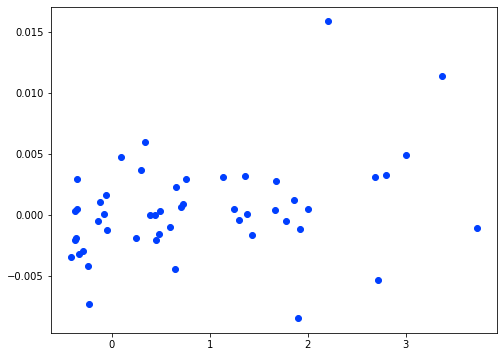

In [158]:
#Plotting the words using matplotlib:

features = model[model.wv.vocab]
for_pca = PCA(n_components = 2)
pca_out = for_pca.fit_transform(features)


plt.figure(figsize = (8,6))
plt.scatter(pca_out[:, 0][0:50], pca_out[:, 1][0:50])

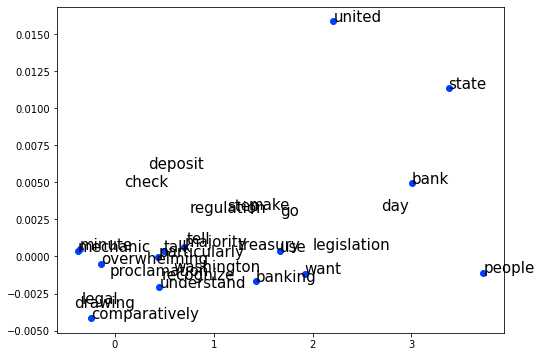

In [159]:
plt.figure(figsize = (8,6))
plt.scatter(pca_out[:, 0][0:15], pca_out[:, 1][0:15])
words = list(model.wv.vocab)
for i, word in enumerate(words[0:30]):
    plt.annotate(word, size = 15, xy=(pca_out[i, 0], pca_out[i, 1]))
plt.show()

###Next Steps:

How can I take this research forward? 

**The dataset:**

Ideally, I'd like to gather every speech given by FDR and Hoover during the Great Depression. This might require further digitalization of the records, and maybe some data scrapping. 

**The Methods:**

The next steps would be approaching these texts from a computational hermeneutics method. 

Using Kenneth Burke's five steps to analyze a text, I will use Named-Entity Recognition to identify the following:

1. what was done (act)
2. when or where it was done (scene)
3. who did it (agent)
4. how he did it (agency)
5. and why (purpose)

This way I hope to have a better overall understanding of what changed in the rhetoric around the Federal Government and the American people. 

##Sentiment Analsys: VADER 

In [162]:
#Removing stop words from both speeches:

sid = SentimentIntensityAnalyzer()
FDR_sentiment = pd.read_csv('/content/drive/My Drive/Juliana/FDR_speeches.csv')
Hoover_sentiment = pd.read_csv('/content/drive/My Drive/Juliana/Hoover_speeches.csv')

def remove_stop_words(text):
    result = []
    for token in text.split():
        if token not in stop_words:
            result.append(token)
    return " ".join(result)


FDR_sentiment['Clean'] = [remove_stop_words(w) for w in FDR_sentiment['Speech']]
Hoover_sentiment['Clean'] = [remove_stop_words(w) for w in Hoover_sentiment['Speech']]


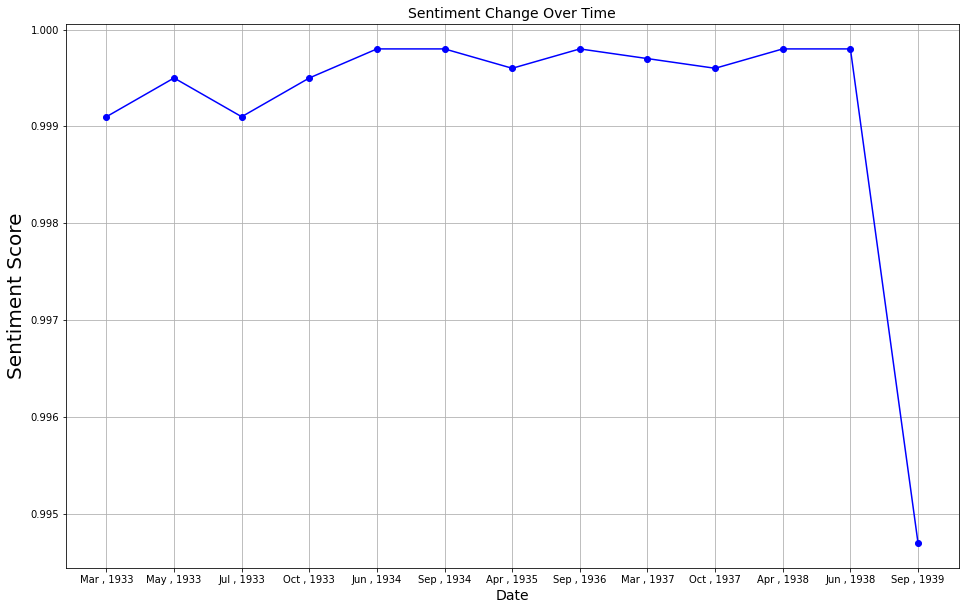

In [163]:
#FDR's Sentiment Analysis

FDR_sentiment['scores'] = FDR_sentiment['Clean'].apply(lambda Speech: sid.polarity_scores(Speech))
FDR_sentiment['compound score']  = FDR_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])
FDR_sentiment['verdict'] = FDR_sentiment['compound score'].apply(lambda c: 'pos' if c >=0 else 'neg')

data = FDR_sentiment

FDR_chart = pd.DataFrame(data,columns=['Date','compound score'])

plt.figure(figsize=(16, 10))
plt.plot(FDR_chart['Date'], FDR_chart['compound score'], color='blue', marker='o')
plt.title('Sentiment Change Over Time', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=20)
plt.yticks()
plt.grid(True)
plt.show()



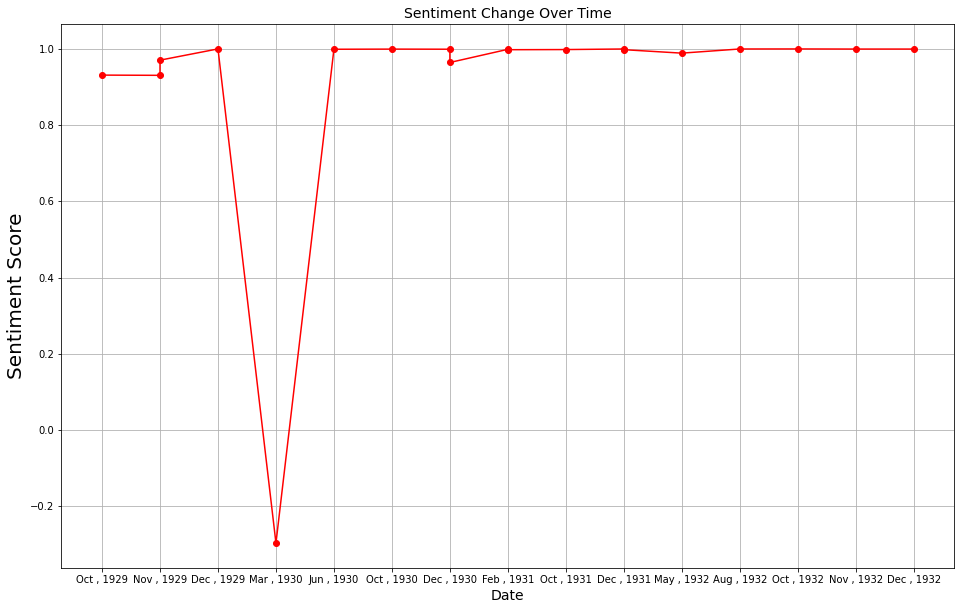

In [164]:
#Hoover's Sentiment Analysis:

Hoover_sentiment['scores'] = Hoover_sentiment['Clean'].apply(lambda Speech: sid.polarity_scores(Speech))
Hoover_sentiment['compound score']  = Hoover_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])
Hoover_sentiment['verdict'] = Hoover_sentiment['compound score'].apply(lambda c: 'pos' if c >=0 else 'neg')

Hoover_data = Hoover_sentiment
Hoover_chart = pd.DataFrame(Hoover_data,columns=['Date','compound score'])

plt.figure(figsize=(16, 10))
plt.plot(Hoover_chart['Date'], Hoover_chart['compound score'], color='red', marker='o')
plt.title('Sentiment Change Over Time', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=20)
plt.yticks()
plt.grid(True)
plt.show()

